# README

This notebook allows conversion of GPS Data from a DJI Mini 3 using .csv flight logs downloaded from AirData.

# I. General

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid
import numpy as np
import argparse
import os
import glob

from datetime import datetime
from sklearn import metrics, svm, tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from geopy import distance 
import math

In [19]:
in_gpsData = ['..\data/raw/gps/GPSData1.csv', '..\data/raw/gps/GPSData2.csv', '..\data/raw/gps/GPSData3.csv', '..\data/raw/gps/GPSData4.csv', '..\data/raw/gps/GPSData5.csv', '..\data/raw/gps/GPSData6.csv']

generativeCycles = 5
scalingRange = [0.5, 2.5]

parser = argparse.ArgumentParser(
                    prog='GPS Conversion',
                    description='Coverts GPS Data to a format resembling processed RADAR data. Files are pulled from data/raw/gps or the provided directory.')

parser.add_argument('-l', '--trackLength', type=int, default=20, help="Tracks will be split into pieces of size trackLength.")
parser.add_argument('-low', '--scalingLowerBound', type=int, default=1, help="Lower bound of the multiplier for scaling of input data.")
parser.add_argument('-high', '--scalingUpperBound', type=int, default=1, help="Upper bound of the multiplier for scaling of input data.")
parser.add_argument('-r', '--reverseTracks', type=bool, default=False, help="Adds reversed versions of each track to the output.")
parser.add_argument('-c', '--cycles', type=int, default=1)

parser.add_argument('-in', "--inPath", type=str, default='../data/raw/gps/unprocessed', nargs='+', help="Processed all files in this directory")
parser.add_argument('-out', "--outName", type=str, default='processedGPSData', nargs='+', help="Output filename")

parser.add_argument('-f', '--files', help='-f is buggy with Jupyter. Ignore this')

args = parser.parse_args()

 # Parse paths
files = set()
files |= set(glob.glob(args.inPath + '/*' + '.csv'))

../data/raw/gps/unprocessed


### Constants

In [20]:
# ecco fields deemed not important by aaron
NI_ECCO = ['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 
           'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 
           'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 
           'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks']

NI_GPS = ['datetime(utc)', 'height_above_takeoff(feet)', 
          'height_above_ground_at_drone_location(feet)', 
          'ground_elevation_at_drone_location(feet)', 
          'height_sonar(feet)', 'distance(feet)', 'mileage(feet)',
          'satellites', 'gpslevel', 'voltage(v)', 'max_altitude(feet)',
          'max_ascent(feet)', 'max_speed(mph)', 'max_distance(feet)',
          ' xSpeed(mph)', ' ySpeed(mph)', ' zSpeed(mph)', ' compass_heading(degrees)', 
          ' pitch(degrees)', ' roll(degrees)', 'isPhoto', 'isVideo', 'rc_elevator',
          'rc_aileron', 'rc_throttle', 'rc_rudder', 'rc_elevator(percent)', 'rc_aileron(percent)',
          'rc_throttle(percent)', 'rc_rudder(percent)', 'gimbal_heading(degrees)',
          'gimbal_pitch(degrees)', 'gimbal_roll(degrees)', 'battery_percent',
          'voltageCell1', 'voltageCell2', 'voltageCell3', 'voltageCell4',
          'voltageCell5', 'voltageCell6', 'current(A)', 'battery_temperature(f)',
          'altitude(feet)', 'ascent(feet)', 'flycStateRaw', 'flycState', 'message']

# fields that only have one or two unique values:
# Source Name:  ['RPS82-90deg' 'ctcve']
# Source Class: ['RADAR']
# Source LID:   [21. 49.]
# Closest Time: [0.]
REPEAT_ECCO = ['Source Name', 'Source Class', 'Source LID', 'Closest Time']

# all other ecco fields (aside from position, velocity, heading)
OTHER_ECCO = ['Name', 'Create Time', 'Object ID', 'Origin Position (lat)',
              'Origin Position (lon)', 'Origin Position (alt MSL)', 'Radar Cross Section',
              'Source ID', 'Deleted', 'Deleted Time']

# the ecco fields related to time
TIME_COLS = ['Create Time', 'Update Time', 'Deleted Time']

# mapping between ecco and simulated
ECCO_SIMU_MAP = {
    'Update Time': 'UpdateTime',
    'Range To Contact': 'Range',
    'Bearing To Contact': 'AZ',
    'EL': 'EL',
    'Position (lat)': 'Position_lat_',
    'Position (lon)': 'Position_lon_',
    'Position (alt MSL)': 'Position_altMSL_',
    'Speed': 'Speed',
    'Radial Velocity': 'RadialVelocity'
}

GPS_MAP = {
    'time(millisecond)': 'UpdateTime',
    'latitude': 'Position_lat_',
    'longitude': 'Position_lon_',
    'altitude_above_seaLevel(feet)': 'Position_altMSL_',
    'speed(mph)': 'Speed',
}


### Helper Functions

In [21]:

def findRange(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    dist3d = np.sqrt(dist2d**2 + (alt2 - alt1)**2)
    return np.abs(dist3d)

def findBearing(lat1, lon1, lat2, lon2):
    brng = np.arctan((lon2-lon1)/(lat2-lat1)) * 360 /2 / math.pi
    if brng < 0: brng+= 360
    return brng

def findElevation(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    elevationAngle = np.arctan((alt2 - alt1)/dist2d) * 360 / 2 / math.pi
    return elevationAngle

def findRadialVelocity(vecX1, vecY1, vecX2, vecY2):
    diffX = vecX2-vecX1
    diffY = vecY2-vecY1
    return np.sqrt(diffX**2 + diffY**2)

### Load and process GPS data

In [22]:
# load gps data
gpsTracks = []
finalTracks = []
gpsData = files

generativeCycles = args.cycles
scalingRange = [args.scalingLowerBound, args.scalingUpperBound]

#Take every 10th row from each .csv (1s intervals), leaving out first and last 10 seconds
for data in gpsData:
    gpsTracks.append(pd.read_csv(data).iloc[200:-200:10, :])

for rep in range(generativeCycles):
    print("Beginning cycle " + rep + ". Current scaling: " + scalingRange[0] + (scalingRange[1]-scalingRange[0])/generativeCycles*rep)

    for track in gpsTracks:
        data = track.copy()

        track_IDs = [None] * len(data)
        ranges = [None] * len(data)
        bearings = [None] * len(data)
        elevations = [None] * len(data)
        radialVels = [None] * len(data)

        latNew = [None] * len(data)
        longNew = [None] * len(data)
        altNew = [None] * len(data)

        radarLat = np.random.uniform(-0.04, 0.04) + data['latitude'].iat[0]
        radarLon = np.random.uniform(-0.04, 0.04) + data['longitude'].iat[0]
        radarAlt = np.random.uniform(-200, 200) + data['altitude_above_seaLevel(feet)'].iat[0]
        scale = scalingRange[0] + (scalingRange[1]-scalingRange[0])/generativeCycles*rep

        lastDiffX = 0
        lastDiffY = 0

        #Speed/Distance scaling
        latNew[0] = data['latitude'].iat[0]
        longNew[0] = data['longitude'].iat[0]
        altNew[0] = data['altitude_above_seaLevel(feet)'].iat[0]

        for i in range(len(data)-1):
            latNew[i+1] = scale*(data['latitude'].iat[i+1]-data['latitude'].iat[i]) + latNew[i]
            longNew[i+1] = scale*(data['longitude'].iat[i+1]-data['longitude'].iat[i]) + longNew[i]
            altNew[i+1] = scale*(data['altitude_above_seaLevel(feet)'].iat[i+1]-data['altitude_above_seaLevel(feet)'].iat[i]) + altNew[i]
            #if (data['speed(mph)'].iat[i] == 0):
            #    data['speed(mph)'].iat[i] = distance.distance([data['longitude'].iat[i+1], data['latitude'].iat[i+1]], [data['longitude'].iat[i], data['latitude'].iat[i]]).m

        data['latitude'] = latNew
        data['longitude'] = longNew
        data['altitude_above_seaLevel(feet)'] = altNew
        data['speed(mph)'] *= scale

        #Split every 20th track
        for i in range(len(data)):

            #Splitting tracks into multiple UUIDs
            if i % 20 == 0:
                if(i+20 < len(data)):
                    id = str(uuid.uuid1())

            #Calculation of range, bearing, elevation angle
            track_IDs[i] = id
            ranges[i] = findRange(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            bearings[i] = findBearing(data['latitude'].iat[i], data['longitude'].iat[i],
                                radarLat, radarLon)
            elevations[i] = findElevation(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            
            currentDiffX = distance.distance([data['latitude'].iat[i], 0], [radarLat, 0]).m
            currentDiffY = distance.distance([data['longitude'].iat[i], 0], [radarLon, 0]).m

            radialVels[i] = findRadialVelocity(lastDiffX, lastDiffY, currentDiffX, currentDiffY)

            lastDiffX = currentDiffX
            lastDiffY = currentDiffY

            # speed unit conversion
            data['speed(mph)'].iat[i]*=0.44704

        data['UUID'] = track_IDs
        data['Range'] = ranges
        data['AZ'] = bearings
        data['EL'] = elevations
        
        # Wasn't letting me drop first row during iteration idk why
        radialVels[0] = radialVels[1]
        data['RadialVelocity'] = radialVels

        finalTracks.append(data)
        
        #Add reversed track
        if(args.reverseTracks):
            data_r = data.copy()
            data_r['speed(mph)'] = data['speed(mph)'].shift(1)
            data_r['time(millisecond)'] = data['time(millisecond)'].values[::-1]

            finalTracks.append(data_r.iloc[1:])

df_gps = pd.concat(finalTracks, ignore_index=True)
df_gps = df_gps.sort_values(by='time(millisecond)', ascending=True)
df_gps.name = 'gpsData.csv'

# drop unimportant columns from gps data
df_gps = df_gps.drop(columns=NI_GPS)
    
# rename all of the gps columns to match ecco
df_gps = df_gps.rename(columns=GPS_MAP, errors='raise')

# show dataframe
df_gps

,UpdateTime,Position_lat_,Position_lon_,Position_altMSL_,Speed,UUID,Range,AZ,EL,RadialVelocity
516,20000,40.429054,-86.929299,628.764045,0.000000,b006e3e8-d516-11ee-9c80-cc153123845c,4324.936874,6.539104,-0.120000,0.040392
1460,20000,40.429532,-86.929320,642.092197,0.000000,b0df068d-d516-11ee-a2c3-cc153123845c,1920.290438,57.955758,-2.924164,0.057070
811,20000,40.429573,-86.929754,656.980130,7.280012,b04b2a5d-d516-11ee-875c-cc153123845c,3148.065162,292.069426,-3.509575,9.015294
2718,20100,40.429021,-86.929275,630.079285,3.260005,b1f3161f-d516-11ee-9587-cc153123845c,3136.483392,346.493007,-2.133406,5.114679
1461,21000,40.429532,-86.929319,645.373037,0.000000,b0df068d-d516-11ee-a2c3-cc153123845c,1920.504856,57.956024,-3.021848,0.057070
...,...,...,...,...,...,...,...,...,...,...
2713,1273300,40.429444,-86.929397,644.388785,0.000000,b1f3161f-d516-11ee-9587-cc153123845c,1909.199378,58.049858,-3.010180,0.716362
2714,1274300,40.429442,-86.929396,644.388785,0.000000,b1f3161f-d516-11ee-9587-cc153123845c,1909.078322,58.056364,-3.010371,0.269693
2715,1275300,40.429442,-86.929396,644.388785,0.000000,b1f3161f-d516-11ee-9587-cc153123845c,1909.081981,58.056918,-3.010365,0.024367
2716,1276300,40.429443,-86.929396,644.388785,0.000000,b1f3161f-d516-11ee-9587-cc153123845c,1909.105432,58.054879,-3.010328,0.081416


### Save new CSV

In [23]:
df_gps.to_csv('..\data/raw/gps/processed/' + args.outName + ".csv", index=False)

print("Saved file to ../data/raw/gps/processed/" + args.outName + ". File contains " + len(df_gps) + " updates.")

### Plot Data

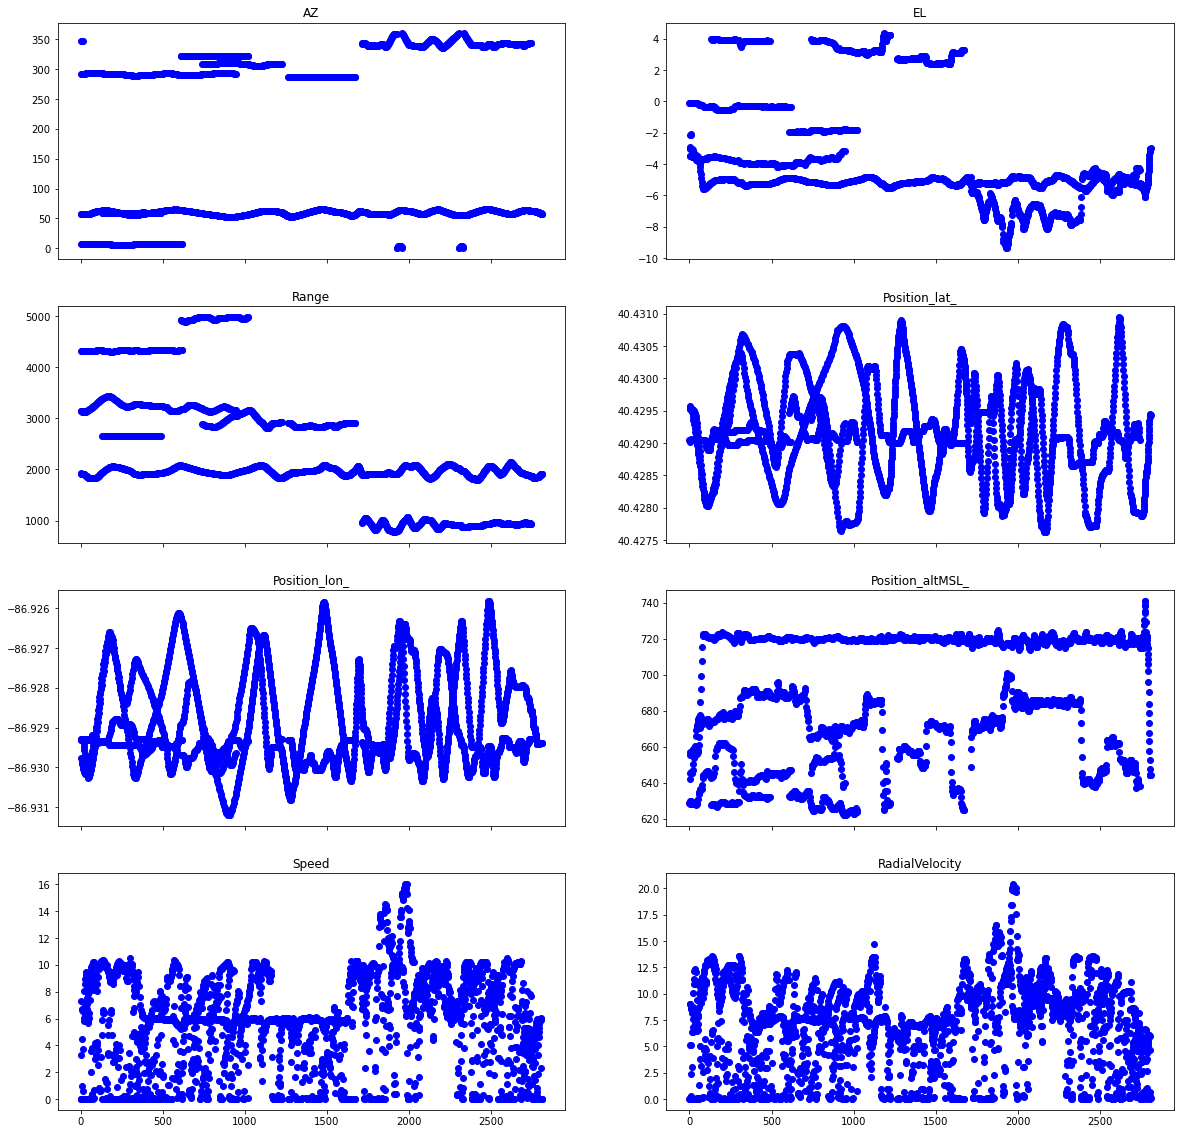

In [24]:
graph = ['AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity']

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,20), sharex=True)

for i, ax in enumerate(axes.flatten()):
    plot = ax.scatter(np.arange(len(df_gps['RadialVelocity'])), df_gps[graph[i]], c='blue')
    ax.set_title(graph[i])